## A 3-step model with Michaelis-Menten (irreversible) kinetics


$$\mbox{S}_\rm{sugar} \overset{\varepsilon_t}{\rightleftharpoons} \mbox{S}_1 \overset{\varepsilon_m}{\rightleftharpoons} S_2 \overset{\varepsilon_r}{\rightleftharpoons} S_3$$

The rate laws are (Michaelis-Menten):
- Transporters:  $v_t = \varepsilon_t ~ k^\mathrm{cat}_t ~ \frac{s_\rm{sugar}}{s_\rm{sugar} + K_{\mathrm{M}, t}}$
- Metabolism:    $v_m = \varepsilon_m ~ k^\mathrm{cat}_m ~ \frac{s_{1}}{s_{1} + K_{\mathrm{M}, m}}$
- Ribosomes:     $v_r = \varepsilon_r ~ k^\mathrm{cat}_r ~ \frac{s_{2}}{s_{2} + K_{\mathrm{M}, r}}$



We assume that $s_0$ is fixed and that the system is at steady-state ($v_t = v_m = v_r = \mu$). The enzymes and metabolites are bound by two constraints:
- $\varepsilon_t + \varepsilon_m + \varepsilon_r \leq \varepsilon^\mathrm{tot}$
- $s_1 + s_2 \leq s_\mathrm{tot}$

Then, the maximal flux (assuming the total enzyme $\varepsilon^\mathrm{tot}$ is distributed optimally) is:
$$\mu = \mu^\mathrm{max} \cdot \frac{s_\mathrm{sugar}}{s_\mathrm{sugar} + K_\mathrm{Monod}}$$
where
$$\mu^\mathrm{max} \equiv \frac{\varepsilon^\mathrm{tot}}{1/k^\mathrm{cat}_t + 1/k^\mathrm{cat}_m + 1/k^\mathrm{cat}_r + \left( \sqrt{K_\mathrm{M,m} / k^\mathrm{cat}_m} + \sqrt{K_\mathrm{M,r}/k^\mathrm{cat}_r} \right)^2 / s_\mathrm{tot}}$$
and
$$K_\mathrm{Monod} \equiv \frac{K_{\mathrm{M,t}} / k^\mathrm{cat}_t}{1/k^\mathrm{cat}_t + 1/k^\mathrm{cat}_m + 1/k^\mathrm{cat}_r + \left( \sqrt{K_\mathrm{M,m} / k^\mathrm{cat}_m} + \sqrt{K_\mathrm{M,r}/k^\mathrm{cat}_r} \right)^2 / s_\mathrm{tot}}$$


The solution for the individual enzyme demands (are):
$$\varepsilon_t^* = \varepsilon^\mathrm{tot} - \mu \left(1/k^\mathrm{cat}_m + 1/k^\mathrm{cat}_r + \left(\sqrt{K_\mathrm{M,m} / k^\mathrm{cat}_m} + \sqrt{K_\mathrm{M,r} / k^\mathrm{cat}_r}\right)^2 / s_\rm{tot}\right)$$
$$\varepsilon_m^* = \mu \left(1/k^\mathrm{cat}_m + \sqrt{K_\mathrm{M,m} / k^\mathrm{cat}_m} \left(\sqrt{K_\mathrm{M,m} / k^\mathrm{cat}_m} + \sqrt{K_\mathrm{M,r} / k^\mathrm{cat}_r}\right) / s_\rm{tot}\right)$$
$$\varepsilon_r^* = \mu \left(1/k^\mathrm{cat}_r + \sqrt{K_\mathrm{M,r} / k^\mathrm{cat}_r} \left(\sqrt{K_\mathrm{M,m} / k^\mathrm{cat}_m} + \sqrt{K_\mathrm{M,r} / k^\mathrm{cat}_r}\right) / s_\rm{tot}\right)$$

<img src="../figures/growing_cell_model.svg" width="800">

In [1]:
import numpy as np
import sympy
import seaborn as sns
from scipy.optimize import minimize, LinearConstraint, Bounds
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["text.usetex"] = True
sympy.init_printing(use_latex=True, scale=2.0, forecolor="black", latex_mode="equation")

In [2]:
# define variables and parameters:
s_tot = sympy.Symbol(r"s_{tot}")
E_tot = sympy.Symbol(r"\varepsilon_{tot}")
s_sugar = sympy.symbols(r"s_{sugar}")
kcat = sympy.symbols(r"k^{cat}_t k^{cat}_m k^{cat}_r")
Km = sympy.symbols(r"K_{M;t} K_{M;m} K_{M;r}")


_denominator = sum(1/k for k in kcat) + (sympy.sqrt(Km[1]/kcat[1]) + sympy.sqrt(Km[2]/kcat[2]))**2 / s_tot
mu_max = E_tot/_denominator
K_monod = Km[0]/kcat[0] / _denominator
J_opt = mu_max * s_sugar / (s_sugar + K_monod)

enzyme_demands = [
    E_tot - J_opt * (1/kcat[1] + 1/kcat[2] + (sympy.sqrt(Km[1]/kcat[1]) + sympy.sqrt(Km[2]/kcat[2]))**2 / s_tot),
    J_opt * (1/kcat[1] + sympy.sqrt(Km[1]/kcat[1]) * (sympy.sqrt(Km[1]/kcat[1]) + sympy.sqrt(Km[2]/kcat[2])) / s_tot),
    J_opt * (1/kcat[2] + sympy.sqrt(Km[2]/kcat[2]) * (sympy.sqrt(Km[1]/kcat[1]) + sympy.sqrt(Km[2]/kcat[2])) / s_tot)
]

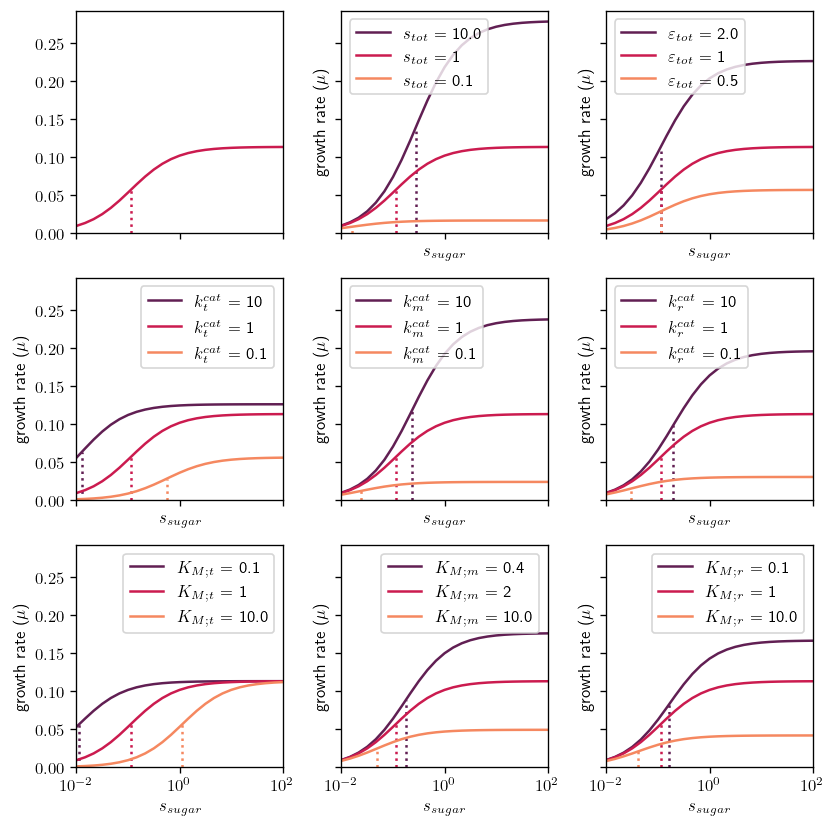

In [3]:
s_sugar_range = np.logspace(-2, 2, 25)
colors = sns.color_palette("rocket", 3)
default_params = {
    Km[0]: 1,
    Km[1]: 2,
    Km[2]: 1,
    kcat[0]: 1,
    kcat[1]: 1,  
    kcat[2]: 1,
    s_tot: 1,
    E_tot: 1,
}
def plot_monod_curve(ax, color=colors[1], key=None, value=None):
    if key is not None:
        p = default_params.copy()
        p[key] = value
        label = f"${sympy.latex(key)}$ = {value}"
    else:
        p = default_params
        label = "default parameters"

    _f = sympy.lambdify(s_sugar, J_opt.subs(p))
    ax.plot(s_sugar_range, _f(s_sugar_range), label=label, color=color)
    K = K_monod.subs(p)
    mu_half = mu_max.subs(p) / 2.0
    ax.plot([K, K], [0, mu_half], ":", color=color, linewidth=1.5)

def plot_three_monod_curves(ax, key, fold_change: float=10.0):
    plot_monod_curve(ax, color=colors[0], key=key, value=default_params[key]*fold_change)
    plot_monod_curve(ax, color=colors[1], key=key, value=default_params[key])
    plot_monod_curve(ax, color=colors[2], key=key, value=default_params[key]/fold_change)
    ax.set_xscale("log")
    ax.set_xlabel(f"${sympy.latex(s_sugar)}$")
    ax.set_ylabel(f"growth rate ($\mu$)")
    ax.set_xlim(1e-2, 1e2)
    ax.set_ylim(0, None)
    ax.legend()

    
fig, axs = plt.subplots(3, 3, figsize=(7, 7), dpi=120, sharex=True, sharey=True)

plot_monod_curve(axs[0, 0])
plot_three_monod_curves(axs[0, 1], key=s_tot, fold_change=10.0)
plot_three_monod_curves(axs[0, 2], key=E_tot, fold_change=2.0)
plot_three_monod_curves(axs[1, 0], key=kcat[0], fold_change=10)
plot_three_monod_curves(axs[1, 1], key=kcat[1], fold_change=10)
plot_three_monod_curves(axs[1, 2], key=kcat[2], fold_change=10)
plot_three_monod_curves(axs[2, 0], key=Km[0], fold_change=0.1)
plot_three_monod_curves(axs[2, 1], key=Km[1], fold_change=0.2)
plot_three_monod_curves(axs[2, 2], key=Km[2], fold_change=0.1)

fig.tight_layout()
fig.savefig("../figures/michaelis_menten_mu_vs_s0.pdf")

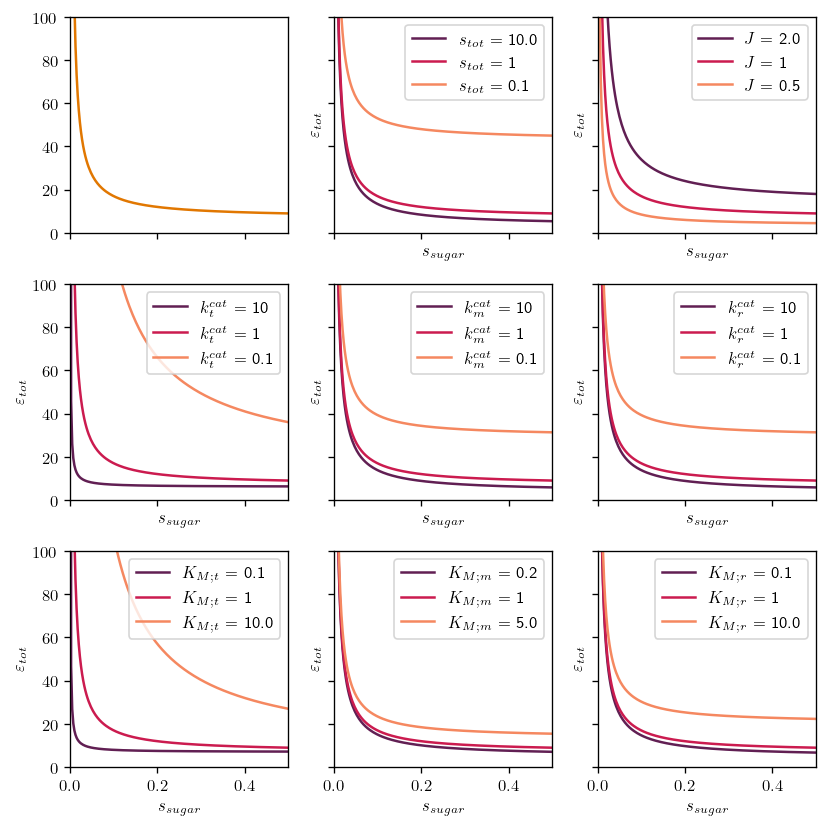

In [4]:
# now plot the enzyme demand per flux:
J_steady_state = sympy.Symbol("J")
s_sugar_range = np.linspace(1e-5, 0.5, 200)
colors = sns.color_palette("rocket", 3)
default_params = {
    Km[0]: 1,
    Km[1]: 1,
    Km[2]: 1,
    kcat[0]: 1,
    kcat[1]: 1,
    kcat[2]: 1,
    s_tot: 1,
    E_tot: 1,
    J_steady_state: 1,
}
enzyme_demand = J_steady_state / J_opt


def plot_enzye_demand(ax, color="#e17701", key=None, value=None):
    if key is not None:
        p = default_params.copy()
        p[key] = value
        label = f"${sympy.latex(key)}$ = {value}"
    else:
        p = default_params
        label = "default parameters"
    _f = sympy.lambdify(s_sugar, enzyme_demand.subs(p))
    ax.plot(s_sugar_range, _f(s_sugar_range), label=label, color=color)

def plot_three_demand_curves(ax, key, fold_change: float=10.0):
    plot_enzye_demand(ax, color=colors[0], key=key, value=default_params[key]*fold_change)
    plot_enzye_demand(ax, color=colors[1], key=key, value=default_params[key])
    plot_enzye_demand(ax, color=colors[2], key=key, value=default_params[key]/fold_change)
    ax.set_xlabel(f"${sympy.latex(s_sugar)}$")
    ax.set_ylabel(r"$\varepsilon_{tot}$")
    ax.set_xlim(0, 0.5)
    ax.set_ylim(0, 100)
    ax.legend()

    
fig, axs = plt.subplots(3, 3, figsize=(7, 7), dpi=120, sharex=True, sharey=True)

plot_enzye_demand(axs[0, 0])
plot_three_demand_curves(axs[0, 1], key=s_tot, fold_change=10.0)
plot_three_demand_curves(axs[0, 2], key=J_steady_state, fold_change=2.0)
plot_three_demand_curves(axs[1, 0], key=kcat[0], fold_change=10)
plot_three_demand_curves(axs[1, 1], key=kcat[1], fold_change=10)
plot_three_demand_curves(axs[1, 2], key=kcat[2], fold_change=10)
plot_three_demand_curves(axs[2, 0], key=Km[0], fold_change=0.1)
plot_three_demand_curves(axs[2, 1], key=Km[1], fold_change=0.2)
plot_three_demand_curves(axs[2, 2], key=Km[2], fold_change=0.1)

fig.tight_layout()
fig.savefig("../figures/michaelis_menten_Etot_vs_s0.pdf")

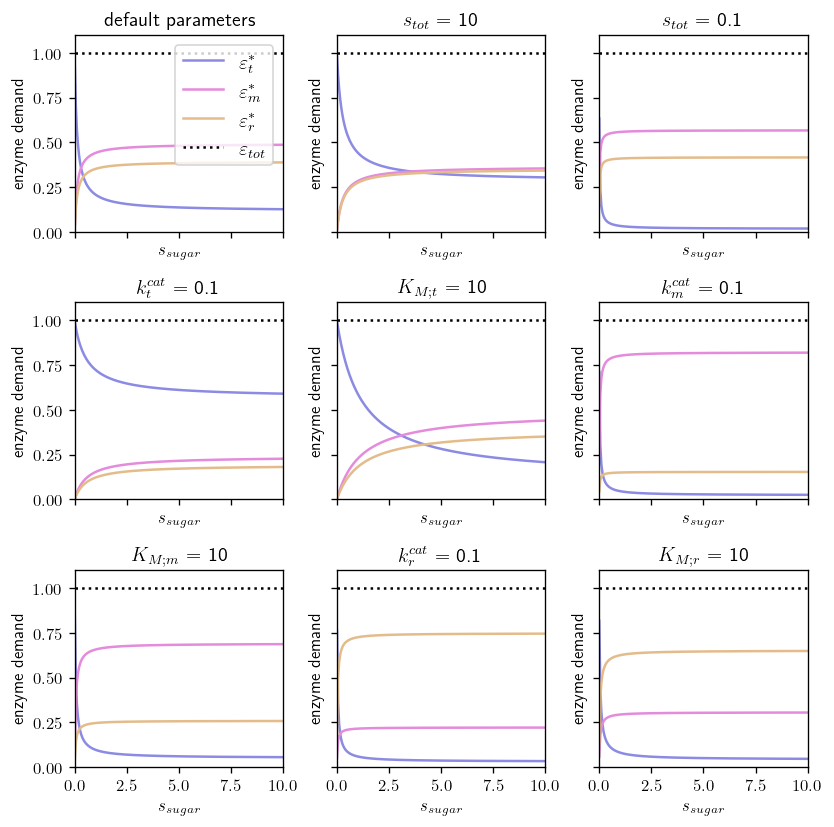

In [5]:
# plot the 3 enzyme demands as a function of s_sugar

s_sugar_range = np.linspace(0.01, 10, 200)
colors = ["#8b8be4", "#e48bdc", "#e4bc8b"]
default_params = {
    Km[0]: 1,
    Km[1]: 2,
    Km[2]: 1,
    kcat[0]: 1,
    kcat[1]: 1.05, # here we adjusted the kcat very slightly in order to avoid overlapping curves in the plots
    kcat[2]: 1,
    s_tot: 1,
    E_tot: 1
}

def plot_demands(ax, key=None, value=None):
    if key is not None:
        p = default_params.copy()
        p[key] = value
        title = f"${sympy.latex(key)}$ = {value}"
    else:
        p = default_params
        title = "default parameters"

    for demand, letter, c in zip(enzyme_demands, ["t", "m", "r"], colors):
        _f = sympy.lambdify(s_sugar, demand.subs(p))
        ax.plot(s_sugar_range, _f(s_sugar_range), label=f"$\\varepsilon^*_{letter}$", color=c)
            
    ax.set_title(title)

fig, axs = plt.subplots(3, 3, figsize=(7, 7), dpi=120, sharex=True, sharey=True)

plot_demands(axs[0, 0])
plot_demands(axs[0, 1], s_tot, 10)
plot_demands(axs[0, 2], s_tot, 0.1)
plot_demands(axs[1, 0], kcat[0], 0.1)
plot_demands(axs[1, 1], Km[0], 10)
plot_demands(axs[1, 2], kcat[1], 0.1)
plot_demands(axs[2, 0], Km[1], 10)
plot_demands(axs[2, 1], kcat[2], 0.1)
plot_demands(axs[2, 2], Km[2], 10)

for ax in axs.flat:
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel(f"${sympy.latex(s_sugar)}$")
    ax.set_ylabel("enzyme demand")
    ax.plot([0, 10], [1, 1], "k:", label=r"$\varepsilon_{tot}$")
axs[0, 0].legend(loc="upper right", fontsize=12)
    
fig.tight_layout()
fig.savefig("../figures/michaelis_menten_demands_vs_s0.pdf")

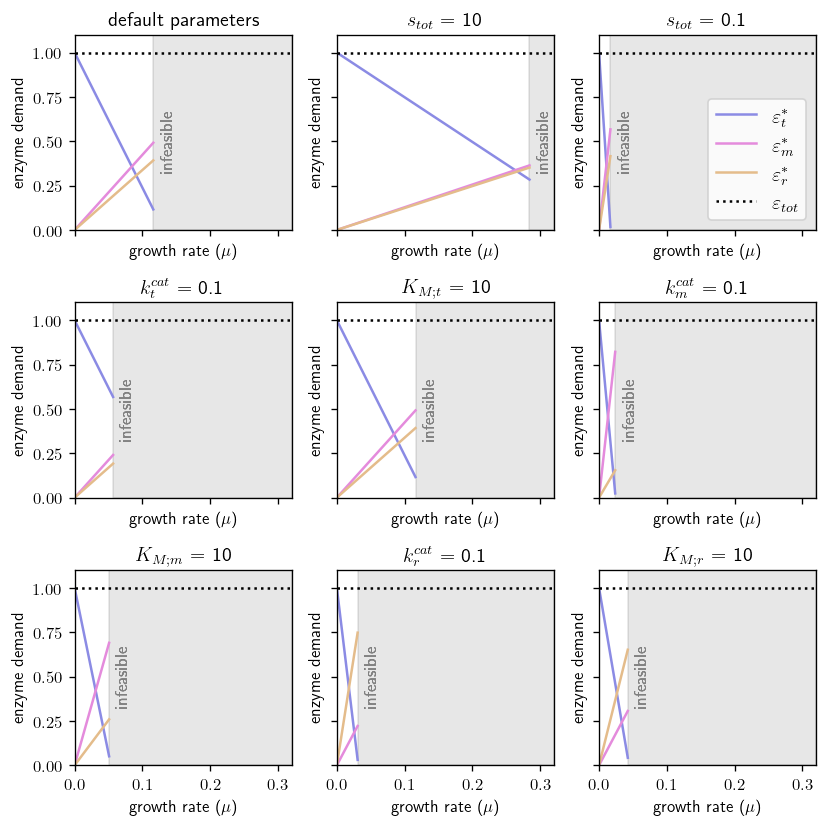

In [6]:
# plot the 3 enzyme demands as a function of J* (for varying s_sugar values)
xmax = 0.32

s_sugar_range = np.logspace(-5, 5, 10)
colors = ["#8b8be4", "#e48bdc", "#e4bc8b"]
default_params = {
    Km[0]: 1,
    Km[1]: 2,
    Km[2]: 1,
    kcat[0]: 1,
    kcat[1]: 1.05, # here we adjusted the kcat very slightly in order to avoid overlapping curves in the plots
    kcat[2]: 1,
    s_tot: 1,
    E_tot: 1
}

def plot_demands(ax, key=None, value=None):
    if key is not None:
        p = default_params.copy()
        p[key] = value
        title = f"${sympy.latex(key)}$ = {value}"
    else:
        p = default_params
        title = "default parameters"

    for demand, letter, c in zip(enzyme_demands, ["t", "m", "r"], colors):
        _f1 = sympy.lambdify(s_sugar, J_opt.subs(p))
        _f2 = sympy.lambdify(s_sugar, demand.subs(p))
        ax.plot(_f1(s_sugar_range), _f2(s_sugar_range), label=f"$\\varepsilon^*_{letter}$", color=c)

        max_flux = mu_max.subs(p)
        ax.axvspan(xmin=max_flux, xmax=xmax, color="black", alpha=0.03)
        if xmax > max_flux:
            ax.text(x=max_flux+0.01, y=0.5, s=r"infeasible", color="grey", rotation=90, verticalalignment="center")
            
    ax.set_title(title)

fig, axs = plt.subplots(3, 3, figsize=(7, 7), dpi=120, sharex=True, sharey=True)

plot_demands(axs[0, 0])
plot_demands(axs[0, 1], s_tot, 10)
plot_demands(axs[0, 2], s_tot, 0.1)
plot_demands(axs[1, 0], kcat[0], 0.1)
plot_demands(axs[1, 1], Km[0], 10)
plot_demands(axs[1, 2], kcat[1], 0.1)
plot_demands(axs[2, 0], Km[1], 10)
plot_demands(axs[2, 1], kcat[2], 0.1)
plot_demands(axs[2, 2], Km[2], 10)

for ax in axs.flat:
    ax.set_xlim(0, xmax)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel(f"growth rate ($\mu$)")
    ax.set_ylabel("enzyme demand")
    ax.plot([0, xmax], [1, 1], "k:", label=r"$\varepsilon_{tot}$")
axs[0, 2].legend(loc="lower right", fontsize=12)
    
fig.tight_layout()
fig.savefig("../figures/michaelis_menten_demands_vs_mu.pdf")

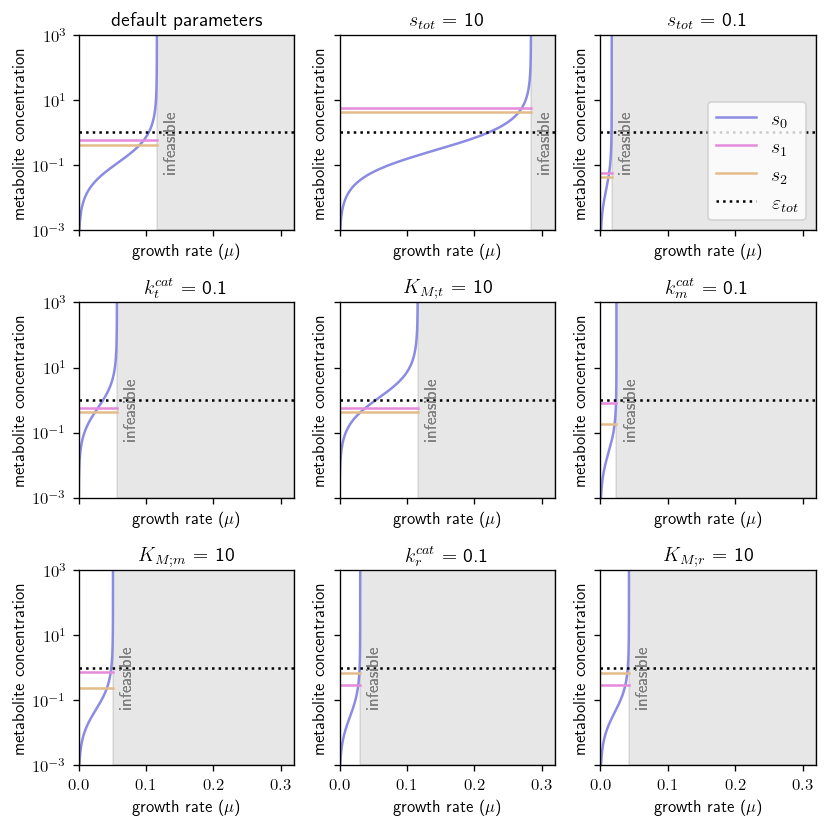

In [7]:
# plot the 3 enzyme demands as a function of s_sugar
xmax = 0.32

# J* = e_i * kcat_i * s_i-1 / (s_i-1 + K_i)   =>   s_i-1 = K_i / (e_i * kcat_i / J* - 1)
metabolite_conc = [
    sympy.simplify(K / (e * k / J_opt - 1))
    for K, e, k in zip(Km, enzyme_demands, kcat)
]

s_sugar_range = np.logspace(-3, 3, 200)
colors = ["#8b8be4", "#e48bdc", "#e4bc8b"]
default_params = {
    Km[0]: 1,
    Km[1]: 2,
    Km[2]: 1,
    kcat[0]: 1,
    kcat[1]: 1.05, # here we adjusted the kcat very slightly in order to avoid overlapping curves in the plots
    kcat[2]: 1,
    s_tot: 1,
    E_tot: 1
}

def plot_metabolites(ax, key=None, value=None):
    if key is not None:
        p = default_params.copy()
        p[key] = value
        title = f"${sympy.latex(key)}$ = {value}"
    else:
        p = default_params
        title = "default parameters"

    for i, conc in enumerate(metabolite_conc):
        _f1 = sympy.lambdify(s_sugar, J_opt.subs(p))
        
        _f2 = sympy.lambdify(s_sugar, conc.subs(p))
        ax.plot(_f1(s_sugar_range), [_f2(s) for s in s_sugar_range], label=f"$s_{i}$", color=colors[i])

        max_flux = mu_max.subs(p)
        ax.axvspan(xmin=max_flux, xmax=xmax, color="black", alpha=0.03)
        if xmax > max_flux:
            ax.text(x=max_flux+0.01, y=0.5, s=r"infeasible", color="grey", rotation=90, verticalalignment="center")
            
    ax.set_title(title)

fig, axs = plt.subplots(3, 3, figsize=(7, 7), dpi=120, sharex=True, sharey=True)

plot_metabolites(axs[0, 0])
plot_metabolites(axs[0, 1], s_tot, 10)
plot_metabolites(axs[0, 2], s_tot, 0.1)
plot_metabolites(axs[1, 0], kcat[0], 0.1)
plot_metabolites(axs[1, 1], Km[0], 10)
plot_metabolites(axs[1, 2], kcat[1], 0.1)
plot_metabolites(axs[2, 0], Km[1], 10)
plot_metabolites(axs[2, 1], kcat[2], 0.1)
plot_metabolites(axs[2, 2], Km[2], 10)

for ax in axs.flat:
    ax.set_xlim(0, xmax)
    ax.set_ylim(1e-3, 1e3)
    ax.set_yscale("log")
    ax.set_xlabel(f"growth rate ($\mu$)")
    ax.set_ylabel("metabolite concentration")
    ax.plot([0, xmax], [1, 1], "k:", label=r"$\varepsilon_{tot}$")
axs[0, 2].legend(loc="lower right", fontsize=12)
    
fig.tight_layout()
fig.savefig("../figures/michaelis_menten_metabolites_vs_mu.pdf")